In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import random
from datetime import datetime

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500
STOPLOSS_UNITS = 3   # <<< CHANGED TO 3 PRICE UNITS

# -------------------------------
# 2. Fetch historical data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# -------------------------------
# 3. Build 0.25 footprint clusters
# -------------------------------
cluster_size = 0.25
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"][i]
    high = df["high_cluster"][i]
    vol = df["tick_volume"][i]
    dt = df["datetime"][i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    for p in price_levels:
        cluster_rows.append([dt, p, vol / len(price_levels)])

cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])

# -------------------------------
# 4. Metric scale
# -------------------------------
max_vol = cluster_df["cluster_vol"].max()
cluster_df["metric"] = cluster_df["cluster_vol"] / max_vol

colorscale = [
    [0.0, "white"],
    [0.25, "#FFDAB9"],
    [0.50, "#FFA500"],
    [0.75, "#FF4500"],
    [1.0, "#8B0000"],
]

# -------------------------------
# 5. Metric spike detection with lookback filter
# -------------------------------
metric_threshold = 0.60

df["raw_spike"] = df["datetime"].apply(
    lambda dt: cluster_df[cluster_df["datetime"] == dt]["metric"].max() >= metric_threshold
)

df["metric_spike"] = False
for i in range(len(df)):
    if df["raw_spike"].iloc[i]:
        lookback_start = max(0, i - 50)
        if not df["metric_spike"].iloc[lookback_start:i].any():
            df.at[i, "metric_spike"] = True
df.drop(columns=["raw_spike"], inplace=True)

df["center"] = (df["high"] + df["low"]) / 2

# -------------------------------
# 6. Backtesting trades with 3-unit stoploss
# -------------------------------
initial_balance = 1000
balance = initial_balance
equity_curve = []
trades = []

risk_per_trade = 0.1
spread = 0.3
commission_pct = 0.01
slippage_max = 1

spike_indices = df.index[df["metric_spike"]].tolist()

for i in range(len(spike_indices)-1):
    entry_idx = spike_indices[i]
    exit_idx = spike_indices[i+1]
    takeprofit_price = df["center"].iloc[exit_idx]

    # ---------------- BuyStop logic ----------------
    entry_price = df["high"].iloc[entry_idx] + spread/2 + random.uniform(0, slippage_max)
    stoploss = entry_price - STOPLOSS_UNITS
    position_risk = balance * risk_per_trade
    executed = False

    for j in range(entry_idx + 1, exit_idx + 1):
        if df["high"].iloc[j] >= entry_price:
            executed = True
            break

    if executed:
        exit_price = takeprofit_price if takeprofit_price > stoploss else stoploss
        exit_price -= spread/2 + random.uniform(0, slippage_max)

        pl_units = exit_price - entry_price
        pl = (pl_units / STOPLOSS_UNITS) * position_risk
        pl -= pl * commission_pct

        balance += pl
        equity_curve.append(balance)

        trades.append({
            "type":"Buy",
            "entry_idx":entry_idx,
            "entry":entry_price,
            "exit":exit_price,
            "PL":pl,
            "R": pl_units / STOPLOSS_UNITS,
            "TP_units": pl_units,
            "SL_units": entry_price - stoploss,
            "PL%": pl / initial_balance * 100
        })

    # ---------------- SellStop logic ----------------
    entry_price = df["low"].iloc[entry_idx] - spread/2 - random.uniform(0, slippage_max)
    stoploss = entry_price + STOPLOSS_UNITS
    position_risk = balance * risk_per_trade
    executed = False

    for j in range(entry_idx + 1, exit_idx + 1):
        if df["low"].iloc[j] <= entry_price:
            executed = True
            break

    if executed:
        exit_price = takeprofit_price if takeprofit_price < stoploss else stoploss
        exit_price += spread/2 + random.uniform(0, slippage_max)

        pl_units = entry_price - exit_price
        pl = (pl_units / STOPLOSS_UNITS) * position_risk
        pl -= pl * commission_pct

        balance += pl
        equity_curve.append(balance)

        trades.append({
            "type":"Sell",
            "entry_idx":entry_idx,
            "entry":entry_price,
            "exit":exit_price,
            "PL":pl,
            "R": pl_units / STOPLOSS_UNITS,
            "TP_units": pl_units,
            "SL_units": stoploss - entry_price,
            "PL%": pl / initial_balance * 100
        })

# -------------------------------
# 7. Compute metrics
# -------------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed")
    mt5.shutdown()
    exit()

num_trades = len(trades_df)
win_trades = trades_df[trades_df["PL"] > 0]
loss_trades = trades_df[trades_df["PL"] <= 0]

win_rate = len(win_trades)/num_trades*100
loss_rate = 100 - win_rate

equity_series = pd.Series(equity_curve)
peak = equity_series.cummax()
drawdown = peak - equity_series
max_dd = drawdown.max()
max_dd_pct = (max_dd / peak.max()) * 100

R_list = trades_df["R"].tolist()
avg_R = np.mean(R_list)
avg_win_R = win_trades["R"].mean() if not win_trades.empty else 0
avg_loss_R = loss_trades["R"].mean() if not loss_trades.empty else 0
expectancy_R = (len(win_trades)/num_trades)*avg_win_R - (len(loss_trades)/num_trades)*avg_loss_R
expectancy_pct = expectancy_R * risk_per_trade * 100

sum_win = win_trades["PL"].sum() if not win_trades.empty else 0.0001
sum_loss = abs(loss_trades["PL"].sum()) if not loss_trades.empty else 0.0001
profit_factor = sum_win / sum_loss

consec_wins = consec_losses = max_consec_wins = max_consec_losses = 0
for pl in trades_df["PL"]:
    if pl > 0:
        consec_wins += 1
        consec_losses = 0
    else:
        consec_losses += 1
        consec_wins = 0
    max_consec_wins = max(max_consec_wins, consec_wins)
    max_consec_losses = max(max_consec_losses, consec_losses)

total_return_pct = (balance - initial_balance)/initial_balance*100
sharpe_ratio = np.mean(np.diff(equity_curve))/np.std(np.diff(equity_curve)) if len(equity_curve)>1 else 0

# -------------------------------
# 8. Print metrics
# -------------------------------
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance:.2f}")
print(f"Total Return %: {total_return_pct:.2f}%")
print(f"Total Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Max Drawdown: {max_dd:.2f} ({max_dd_pct:.2f}%)")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Average R-multiple: {avg_R:.2f}")
print(f"Expectancy (R): {expectancy_R:.2f}")
print(f"Expectancy (% of capital): {expectancy_pct:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Max Consecutive Wins: {max_consec_wins}")
print(f"Max Consecutive Losses: {max_consec_losses}")
print(f"Highest R-multiple: {trades_df['R'].max():.2f}")
print(f"Lowest R-multiple: {trades_df['R'].min():.2f}")
print(f"Average Profit %: {win_trades['PL%'].mean():.2f}%")
print(f"Average Loss %: {loss_trades['PL%'].mean():.2f}%")
print(f"Maximum Take Profit (price units): {trades_df['TP_units'].max():.2f}")
print(f"Maximum Stoploss (price units): {trades_df['SL_units'].max():.2f}")

# -------------------------------
# 9. Plot footprint + trades
# -------------------------------
fig = go.Figure()
fig.add_trace(go.Heatmap(
    x=cluster_df["datetime"],
    y=cluster_df["price"],
    z=cluster_df["metric"],
    colorscale=colorscale,
    zmin=0,
    zmax=1,
    showscale=True,
    name="Footprint Metric"
))

spike_rows = df[df["metric_spike"]]
fig.add_trace(go.Scatter(
    x=spike_rows["datetime"],
    y=spike_rows["center"],
    mode="markers",
    marker=dict(size=16, color="red", symbol="circle"),
    name="Metric Spike"
))

for _, trade in trades_df.iterrows():
    color = "green" if trade["type"]=="Buy" else "red"
    symbol_entry = "triangle-up" if trade["type"]=="Buy" else "triangle-down"
    symbol_exit = "x"
    dt_entry = df["datetime"].iloc[trade["entry_idx"]]

    fig.add_trace(go.Scatter(
        x=[dt_entry], y=[trade["entry"]],
        mode="markers",
        marker=dict(size=12, color=color, symbol=symbol_entry),
        name=f"{trade['type']} Entry"
    ))

    fig.add_trace(go.Scatter(
        x=[dt_entry], y=[trade["exit"]],
        mode="markers",
        marker=dict(size=12, color=color, symbol=symbol_exit),
        name=f"{trade['type']} Exit"
    ))

fig.update_layout(
    title="Heatmap Candle Chart with Trades",
    xaxis_title="Datetime",
    yaxis_title="Price",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=1800,
    height=500
)

# -------------------------------
# 10. Plot equity curve
# -------------------------------
fig_eq = go.Figure()
fig_eq.add_trace(go.Scatter(
    x=np.arange(len(equity_curve)),
    y=equity_curve,
    mode="lines+markers",
    name="Equity Curve"
))
fig_eq.update_layout(
    title="Equity Curve",
    xaxis_title="Trade Number",
    yaxis_title="Balance",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=1800,
    height=500
)

fig.show()
fig_eq.show()
mt5.shutdown()


No trades executed


KeyError: 'PL'

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import random
from datetime import datetime

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# 2. Fetch historical data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# -------------------------------
# 3. Build 0.25 footprint clusters
# -------------------------------
cluster_size = 0.25
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"][i]
    high = df["high_cluster"][i]
    vol = df["tick_volume"][i]
    dt = df["datetime"][i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    for p in price_levels:
        cluster_rows.append([dt, p, vol / len(price_levels)])

cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])

# -------------------------------
# 4. Metric scale
# -------------------------------
max_vol = cluster_df["cluster_vol"].max()
cluster_df["metric"] = cluster_df["cluster_vol"] / max_vol

colorscale = [
    [0.0, "white"],
    [0.25, "#FFDAB9"],
    [0.50, "#FFA500"],
    [0.75, "#FF4500"],
    [1.0, "#8B0000"],
]

# -------------------------------
# 5. Metric spike detection with 10-bar lookback
# -------------------------------
metric_threshold = 0.60

df["raw_spike"] = df["datetime"].apply(
    lambda dt: cluster_df[cluster_df["datetime"] == dt]["metric"].max() >= metric_threshold
)

df["metric_spike"] = False
for i in range(len(df)):
    if df["raw_spike"].iloc[i]:
        lookback_start = max(0, i - 50)
        if not df["metric_spike"].iloc[lookback_start:i].any():
            df.at[i, "metric_spike"] = True
df.drop(columns=["raw_spike"], inplace=True)

df["center"] = (df["high"] + df["low"]) / 2

# -------------------------------
# 6. Backtesting trades with adjustable risk
# -------------------------------
initial_balance = 1000
balance = initial_balance
equity_curve = []
trades = []

risk_per_trade = 0.01  # 1% adjustable risk per trade
spread = 0.3           # price units
commission_pct = 0.01  # 1% of risk per trade
slippage_max = 1       # random slippage in price units
stoploss_units = 3     # updated stoploss

spike_indices = df.index[df["metric_spike"]].tolist()

for i in range(len(spike_indices)-1):
    entry_idx = spike_indices[i]
    exit_idx = spike_indices[i+1]
    takeprofit_price = df["center"].iloc[exit_idx]

    # ---------------- BuyStop logic ----------------
    entry_price = df["high"].iloc[entry_idx] + spread/2 + random.uniform(0, slippage_max)
    stoploss = entry_price - stoploss_units
    position_risk = balance * risk_per_trade
    executed = False
    for j in range(entry_idx + 1, exit_idx + 1):
        if df["high"].iloc[j] >= entry_price:
            executed = True
            break
    if executed:
        exit_price = max(takeprofit_price, stoploss) if takeprofit_price > entry_price else stoploss
        exit_price -= spread/2 + random.uniform(0, slippage_max)
        pl_units = exit_price - entry_price
        pl = (pl_units / stoploss_units) * position_risk
        pl -= pl * commission_pct
        balance += pl
        equity_curve.append(balance)
        trades.append({
            "type":"Buy",
            "entry_idx":entry_idx,
            "entry":entry_price,
            "exit":exit_price,
            "PL":pl,
            "R": pl_units/stoploss_units,
            "TP_units": pl_units,
            "SL_units": entry_price-stoploss,
            "PL%": pl/initial_balance*100
        })

    # ---------------- SellStop logic ----------------
    entry_price = df["low"].iloc[entry_idx] - spread/2 - random.uniform(0, slippage_max)
    stoploss = entry_price + stoploss_units
    position_risk = balance * risk_per_trade
    executed = False
    for j in range(entry_idx + 1, exit_idx + 1):
        if df["low"].iloc[j] <= entry_price:
            executed = True
            break
    if executed:
        exit_price = min(takeprofit_price, stoploss) if takeprofit_price < entry_price else stoploss
        exit_price += spread/2 + random.uniform(0, slippage_max)
        pl_units = entry_price - exit_price
        pl = (pl_units / stoploss_units) * position_risk
        pl -= pl * commission_pct
        balance += pl
        equity_curve.append(balance)
        trades.append({
            "type":"Sell",
            "entry_idx":entry_idx,
            "entry":entry_price,
            "exit":exit_price,
            "PL":pl,
            "R": pl_units/stoploss_units,
            "TP_units": pl_units,
            "SL_units": stoploss-entry_price,
            "PL%": pl/initial_balance*100
        })

# -------------------------------
# 7. Compute metrics
# -------------------------------
trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed")
    mt5.shutdown()
    exit()

num_trades = len(trades_df)
win_trades = trades_df[trades_df["PL"] > 0]
loss_trades = trades_df[trades_df["PL"] <= 0]

win_rate = len(win_trades)/num_trades*100
loss_rate = 100 - win_rate

equity_series = pd.Series(equity_curve)
peak = equity_series.cummax()
drawdown = peak - equity_series
max_dd = drawdown.max()
max_dd_pct = (max_dd / peak.max()) * 100

R_list = trades_df["R"].tolist()
avg_R = np.mean(R_list)
avg_win_R = win_trades["R"].mean() if not win_trades.empty else 0
avg_loss_R = loss_trades["R"].mean() if not loss_trades.empty else 0
expectancy_R = (len(win_trades)/num_trades)*avg_win_R - (len(loss_trades)/num_trades)*avg_loss_R
expectancy_pct = expectancy_R * risk_per_trade * 100

sum_win = win_trades["PL"].sum() if not win_trades.empty else 0.0001
sum_loss = abs(loss_trades["PL"].sum()) if not loss_trades.empty else 0.0001
profit_factor = sum_win / sum_loss

consec_wins = consec_losses = max_consec_wins = max_consec_losses = 0
for pl in trades_df["PL"]:
    if pl > 0:
        consec_wins += 1
        consec_losses = 0
    else:
        consec_losses += 1
        consec_wins = 0
    max_consec_wins = max(max_consec_wins, consec_wins)
    max_consec_losses = max(max_consec_losses, consec_losses)

total_return_pct = (balance - initial_balance)/initial_balance*100
sharpe_ratio = np.mean(np.diff(equity_curve))/np.std(np.diff(equity_curve)) if len(equity_curve)>1 else 0

# -------------------------------
# 8. Print metrics
# -------------------------------
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance:.2f}")
print(f"Total Return %: {total_return_pct:.2f}%")
print(f"Total Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Max Drawdown: {max_dd:.2f} ({max_dd_pct:.2f}%)")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Average R-multiple: {avg_R:.2f}")
print(f"Expectancy (R): {expectancy_R:.2f}")
print(f"Expectancy (% of capital): {expectancy_pct:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Max Consecutive Wins: {max_consec_wins}")
print(f"Max Consecutive Losses: {max_consec_losses}")
print(f"Highest R-multiple: {trades_df['R'].max():.2f}")
print(f"Lowest R-multiple: {trades_df['R'].min():.2f}")
print(f"Average Profit %: {win_trades['PL%'].mean():.2f}%")
print(f"Average Loss %: {loss_trades['PL%'].mean():.2f}%")
print(f"Maximum Take Profit (price units): {trades_df['TP_units'].max():.2f}")
print(f"Maximum Stoploss (price units): {trades_df['SL_units'].max():.2f}")

# -------------------------------
# 9. Plot footprint + trades
# -------------------------------
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x=cluster_df["datetime"],
        y=cluster_df["price"],
        z=cluster_df["metric"],
        colorscale=colorscale,
        zmin=0,
        zmax=1,
        showscale=True,
        name="Footprint Metric"
    )
)
spike_rows = df[df["metric_spike"]]
fig.add_trace(
    go.Scatter(
        x=spike_rows["datetime"],
        y=spike_rows["center"],
        mode="markers",
        marker=dict(size=16, color="red", symbol="circle"),
        name="Metric Spike"
    )
)
for _, trade in trades_df.iterrows():
    color = "green" if trade["type"]=="Buy" else "red"
    symbol_entry = "triangle-up" if trade["type"]=="Buy" else "triangle-down"
    symbol_exit = "x"
    dt_entry = df["datetime"].iloc[trade["entry_idx"]]
    fig.add_trace(go.Scatter(x=[dt_entry], y=[trade["entry"]], mode="markers",
                             marker=dict(size=12, color=color, symbol=symbol_entry), name=f"{trade['type']} Entry"))
    fig.add_trace(go.Scatter(x=[dt_entry], y=[trade["exit"]], mode="markers",
                             marker=dict(size=12, color=color, symbol=symbol_exit), name=f"{trade['type']} Exit"))
fig.update_layout(title="Heatmap Candle Chart with Trades",
                  xaxis_title="Datetime", yaxis_title="Price",
                  plot_bgcolor="white", paper_bgcolor="white",
                  width=1800, height=500)

# -------------------------------
# 10. Plot equity curve
# -------------------------------
fig_eq = go.Figure()
fig_eq.add_trace(go.Scatter(x=np.arange(len(equity_curve)), y=equity_curve,
                            mode="lines+markers", line=dict(color="gold", width=2), name="Equity Curve"))
fig_eq.update_layout(title="Equity Curve", xaxis_title="Trade Number", yaxis_title="Balance",
                     plot_bgcolor="white", paper_bgcolor="white", width=1800, height=500)

fig.show()
fig_eq.show()
mt5.shutdown()


No trades executed


KeyError: 'PL'

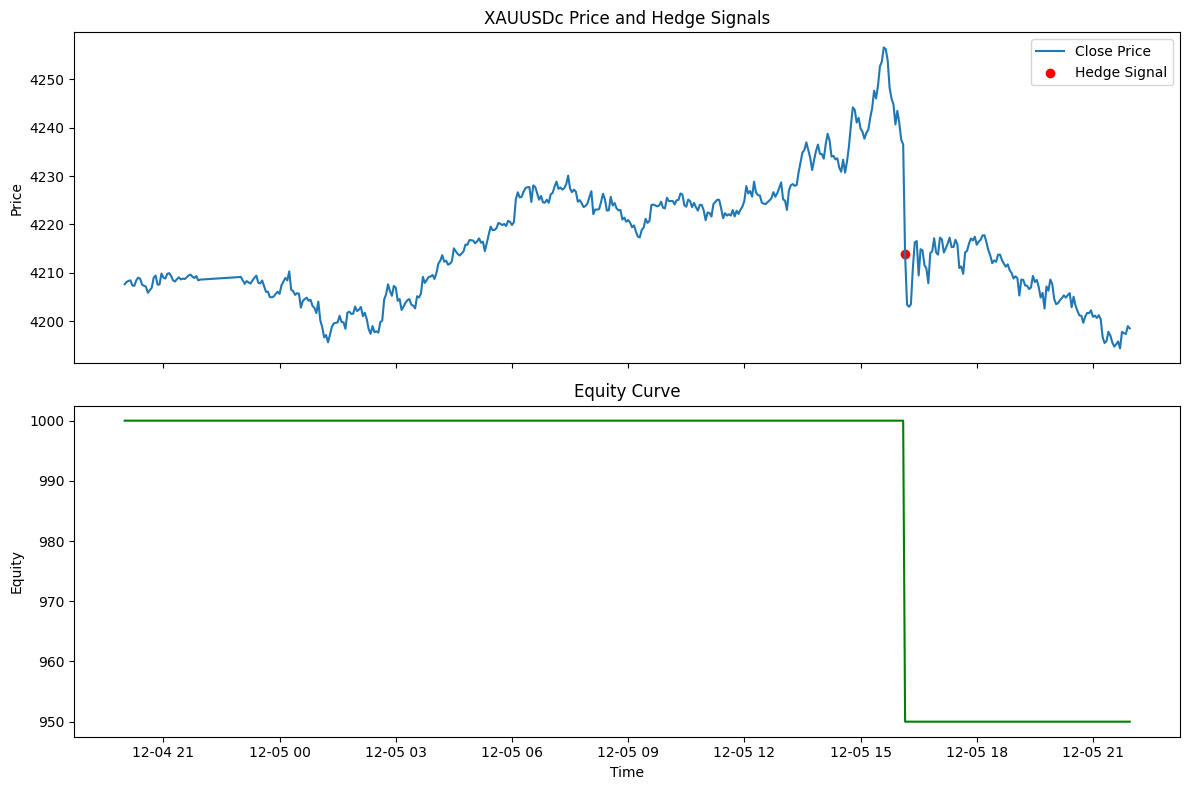

True

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# 2. Fetch data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Step 1–2: Tick-Volume Heatmap and Metric Scaling
# -------------------------------
# Simulate tick-volume as volume (MT5 does not provide tick-level by default)
df['TV'] = df['tick_volume']

# Aggregate tick-volume into 0.25 price bins (simplified)
price_min = df['low'].min()
price_max = df['high'].max()
bins = np.arange(price_min, price_max + 0.25, 0.25)

def heatmap_metric(row):
    bin_vols = np.histogram([row['close']], bins=bins, weights=[row['TV']])[0]
    return bin_vols.sum()

df['HM'] = df.apply(heatmap_metric, axis=1)

# Normalize metric to [0,1]
df['M'] = (df['HM'] - df['HM'].min()) / (df['HM'].max() - df['HM'].min())

# -------------------------------
# 4. Step 3–5: Metric Spike and Hedge Signal
# -------------------------------
MT = 0.8       # example metric threshold
lookback = 5   # example number of candles

df['MS1'] = (df['M'] >= MT).astype(int)
df['NC'] = df['MS1'].rolling(lookback).apply(lambda x: int(x[:-1].sum() == 0), raw=True)
df['NC'] = df['NC'].fillna(1).astype(int)
df['HS'] = df['MS1'] * df['NC']

# -------------------------------
# 5. Step 6–9: Trade simulation
# -------------------------------
initial_equity = 1000
equity = [initial_equity]
position_size = 0
stop_loss_units = 3

for i in range(len(df)):
    hs = df['HS'].iloc[i]
    entry_price = df['close'].iloc[i]
    
    if hs == 1:
        # simple long/short entry: long if price moves up, short if price moves down
        # For example, here we just go long
        pos = 0.05 * equity[-1] / stop_loss_units  # 5% risk
        target_price = entry_price + 1  # dynamic TP placeholder
        sl = entry_price - stop_loss_units
        
        # next bar PnL simulation
        next_price = df['close'].iloc[i+1] if i+1 < len(df) else entry_price
        pnl = pos * (next_price - entry_price)
        if next_price <= sl:
            pnl = pos * (sl - entry_price)
    else:
        pnl = 0
    equity.append(equity[-1] + pnl)

df['Equity'] = equity[1:]

# -------------------------------
# 6. Step 10: Plot chart and equity curve
# -------------------------------
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), sharex=True)

# Price chart
ax1.plot(df['time'], df['close'], label='Close Price')
ax1.scatter(df['time'][df['HS']==1], df['close'][df['HS']==1], color='red', label='Hedge Signal')
ax1.set_title('XAUUSDc Price and Hedge Signals')
ax1.set_ylabel('Price')
ax1.legend()

# Equity curve
ax2.plot(df['time'], df['Equity'], color='green')
ax2.set_title('Equity Curve')
ax2.set_ylabel('Equity')
ax2.set_xlabel('Time')

plt.tight_layout()
plt.show()

# -------------------------------
# 7. Shutdown MT5
# -------------------------------
mt5.shutdown()


Initial Balance: 1000
Final Balance: 998.37
Total Return %: -0.16%
Total Trades: 5
Win Rate: 40.00%
Max Drawdown: 0.65
Sharpe Ratio: -10.43
Highest R-multiple: 0.04
Lowest R-multiple: -0.19
Average Profit %: 0.02%
Average Loss %: -0.07%
Maximum Take Profit (price units): 0.18
Maximum Stoploss (price units): 5.00


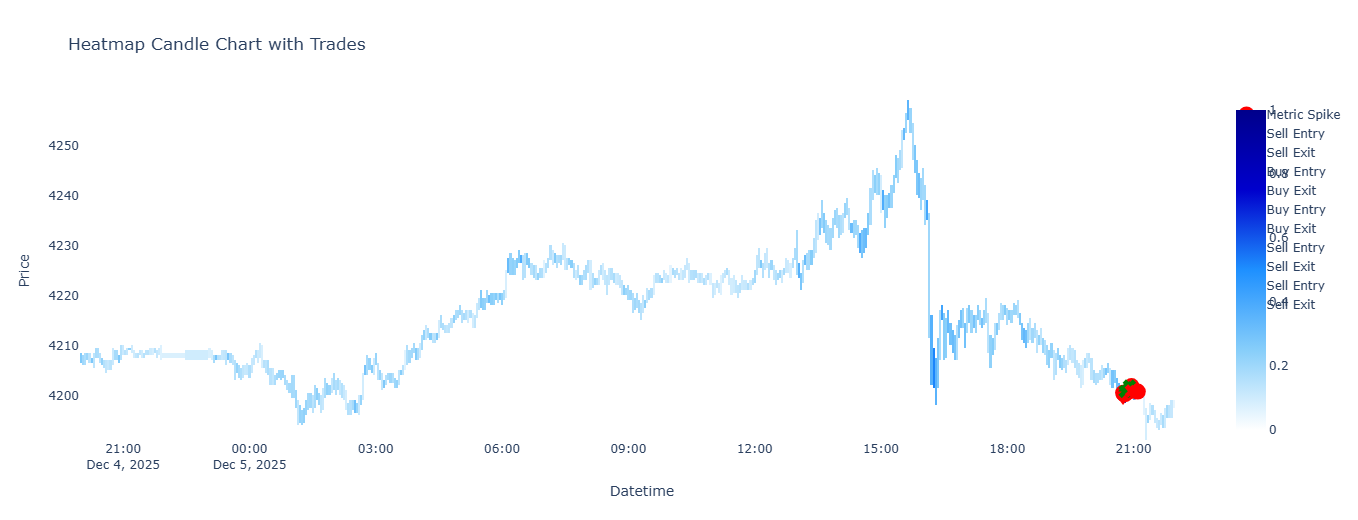

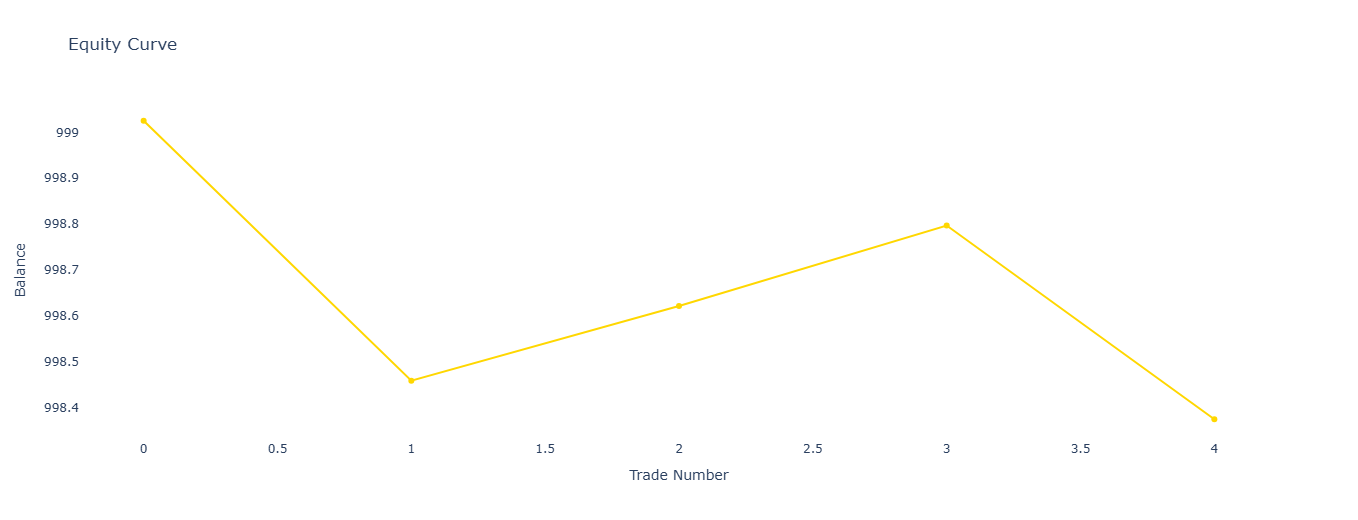

True

In [3]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# 2. Fetch historical data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# -------------------------------
# 3. Build 0.5 footprint clusters
# -------------------------------
cluster_size = 0.5
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"][i]
    high = df["high_cluster"][i]
    vol = df["tick_volume"][i]
    dt = df["datetime"][i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    for p in price_levels:
        cluster_rows.append([dt, p, vol / len(price_levels)])

cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])

# -------------------------------
# 4. Metric scale
# -------------------------------
max_vol = cluster_df["cluster_vol"].max()
cluster_df["metric"] = cluster_df["cluster_vol"] / max_vol

colorscale = [
    [0.0, "white"],
    [0.25, "#87CEFA"],
    [0.50, "#1E90FF"],
    [0.75, "#0000CD"],
    [1.0, "#00008B"],
]

# -------------------------------
# 5. Metric spike detection
# -------------------------------
metric_threshold = 0.60
df["metric_spike"] = df["datetime"].apply(
    lambda dt: cluster_df[cluster_df["datetime"] == dt]["metric"].max() >= metric_threshold
)
df["center"] = (df["high"] + df["low"]) / 2

# -------------------------------
# 6. Backtesting trades
# -------------------------------
initial_balance = 1000
balance = initial_balance
equity_curve = []
trades = []

spike_indices = df.index[df["metric_spike"]].tolist()

for i in range(len(spike_indices)-1):
    entry_idx = spike_indices[i]
    exit_idx = spike_indices[i+1]
    takeprofit_price = df["center"].iloc[exit_idx]

    # BuyStop logic
    entry_price = df["high"].iloc[entry_idx]
    stoploss = entry_price - 5
    executed = False
    for j in range(entry_idx + 1, exit_idx + 1):
        if df["high"].iloc[j] >= entry_price:
            executed = True
            break
    if executed:
        exit_price = takeprofit_price if takeprofit_price > stoploss else stoploss
        pl = exit_price - entry_price
        balance += pl
        equity_curve.append(balance)
        trades.append({"type":"Buy", "entry_idx":entry_idx, "entry":entry_price, "exit":exit_price,
                       "PL":pl, "R": pl/5, "TP_units": exit_price-entry_price, "SL_units": entry_price-stoploss,
                       "PL%": pl/initial_balance*100})

    # SellStop logic
    entry_price = df["low"].iloc[entry_idx]
    stoploss = entry_price + 5
    executed = False
    for j in range(entry_idx + 1, exit_idx + 1):
        if df["low"].iloc[j] <= entry_price:
            executed = True
            break
    if executed:
        exit_price = takeprofit_price if takeprofit_price < stoploss else stoploss
        pl = entry_price - exit_price
        balance += pl
        equity_curve.append(balance)
        trades.append({"type":"Sell", "entry_idx":entry_idx, "entry":entry_price, "exit":exit_price,
                       "PL":pl, "R": pl/5, "TP_units": entry_price-exit_price, "SL_units": stoploss-entry_price,
                       "PL%": pl/initial_balance*100})

trades_df = pd.DataFrame(trades)
if trades_df.empty:
    print("No trades executed")
    mt5.shutdown()
    exit()

# -------------------------------
# 7. Compute metrics
# -------------------------------
num_trades = len(trades_df)
win_trades = trades_df[trades_df["PL"] > 0]
loss_trades = trades_df[trades_df["PL"] <= 0]

win_rate = len(win_trades)/num_trades*100
max_dd = (pd.Series(equity_curve).cummax() - pd.Series(equity_curve)).max()
sharpe_ratio = (trades_df["PL"].mean()/trades_df["PL"].std()*np.sqrt(252)) if len(trades_df)>1 else 0
highest_R = trades_df["R"].max()
lowest_R = trades_df["R"].min()
avg_profit_pct = win_trades["PL%"].mean()
avg_loss_pct = loss_trades["PL%"].mean()
max_tp_units = trades_df["TP_units"].max()
max_sl_units = trades_df["SL_units"].max()
total_return_pct = (balance - initial_balance)/initial_balance*100

# -------------------------------
# 8. Print metrics
# -------------------------------
print(f"Initial Balance: {initial_balance}")
print(f"Final Balance: {balance:.2f}")
print(f"Total Return %: {total_return_pct:.2f}%")
print(f"Total Trades: {num_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Max Drawdown: {max_dd:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Highest R-multiple: {highest_R:.2f}")
print(f"Lowest R-multiple: {lowest_R:.2f}")
print(f"Average Profit %: {avg_profit_pct:.2f}%")
print(f"Average Loss %: {avg_loss_pct:.2f}%")
print(f"Maximum Take Profit (price units): {max_tp_units:.2f}")
print(f"Maximum Stoploss (price units): {max_sl_units:.2f}")

# -------------------------------
# 9. Plot footprint + trade markers
# -------------------------------
fig = go.Figure()

# Heatmap footprint
fig.add_trace(
    go.Heatmap(
        x=cluster_df["datetime"],
        y=cluster_df["price"],
        z=cluster_df["metric"],
        colorscale=colorscale,
        zmin=0,
        zmax=1,
        showscale=True,
        name="Footprint Metric"
    )
)

# Metric spike markers
spike_rows = df[df["metric_spike"]]
fig.add_trace(
    go.Scatter(
        x=spike_rows["datetime"],
        y=spike_rows["center"],
        mode="markers",
        marker=dict(size=16, color="red", symbol="circle"),
        name="Metric Spike"
    )
)

# Trade markers
for _, trade in trades_df.iterrows():
    color = "green" if trade["type"]=="Buy" else "red"
    symbol_entry = "triangle-up" if trade["type"]=="Buy" else "triangle-down"
    symbol_exit = "x"
    dt_entry = df["datetime"].iloc[trade["entry_idx"]]
    # Entry
    fig.add_trace(
        go.Scatter(
            x=[dt_entry],
            y=[trade["entry"]],
            mode="markers",
            marker=dict(size=12, color=color, symbol=symbol_entry),
            name=f"{trade['type']} Entry"
        )
    )
    # Exit
    fig.add_trace(
        go.Scatter(
            x=[dt_entry],
            y=[trade["exit"]],
            mode="markers",
            marker=dict(size=12, color=color, symbol=symbol_exit),
            name=f"{trade['type']} Exit"
        )
    )

fig.update_layout(
    title="Heatmap Candle Chart with Trades",
    xaxis_title="Datetime",
    yaxis_title="Price",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=1800,      # Increased width
    height=500,     # Increased height
)


# -------------------------------
# 10. Plot equity curve
# -------------------------------
fig_eq = go.Figure()
fig_eq.add_trace(go.Scatter(
    x=np.arange(len(equity_curve)),
    y=equity_curve,
    mode="lines+markers",
    line=dict(color="gold", width=2),
    name="Equity Curve"
))
fig_eq.update_layout(
    title="Equity Curve",
    xaxis_title="Trade Number",
    yaxis_title="Balance",
    plot_bgcolor="white",
    paper_bgcolor="white",
    width=1800,      # Increased width
    height=500,     # Increased height
)

fig.show()
fig_eq.show()
mt5.shutdown()

In [ ]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.cluster import KMeans

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    quit()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
num_bars = 500

# -------------------------------
# 2. Fetch historical data
# -------------------------------
rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, num_bars)
df = pd.DataFrame(rates)
df["datetime"] = pd.to_datetime(df["time"], unit="s")

# -------------------------------
# 3. Build 0.25 footprint clusters
# -------------------------------
cluster_size = 0.25
df["low_cluster"] = np.floor(df["low"] / cluster_size) * cluster_size
df["high_cluster"] = np.floor(df["high"] / cluster_size) * cluster_size

cluster_rows = []
for i in range(len(df)):
    low = df["low_cluster"][i]
    high = df["high_cluster"][i]
    vol = df["tick_volume"][i]
    dt = df["datetime"][i]
    price_levels = np.arange(low, high + cluster_size, cluster_size)
    for p in price_levels:
        cluster_rows.append([dt, p, vol / len(price_levels)])
cluster_df = pd.DataFrame(cluster_rows, columns=["datetime", "price", "cluster_vol"])

# -------------------------------
# 4. Metric scale
# -------------------------------
min_vol = cluster_df["cluster_vol"].min()
max_vol = cluster_df["cluster_vol"].max()
cluster_df["metric"] = (cluster_df["cluster_vol"] - min_vol) / (max_vol - min_vol)

# -------------------------------
# 5. Hedge Signal Logic (Metric Spike v2)
# -------------------------------
metric_thresholds = np.arange(0.60, 1.01, 0.05)  # 0.60, 0.65, ..., 1
numlook_checks = np.arange(1, 501)              # 1 to 500
equity_init = 1000
SL_units = 3
risk_pct = 0.05
slippage = 2.0
spread = 0.6
commission_pct = 0.02
num_monte_carlo = 100

# Helper function: backtest single parameter pair
def backtest(metric_threshold, numlook):
    df["metric_spike_v1"] = df["datetime"].apply(
        lambda dt: cluster_df[cluster_df["datetime"] == dt]["metric"].max() >= metric_threshold
    )
    df["metric_spike_v2"] = False
    for i in range(len(df)):
        if df["metric_spike_v1"].iloc[i]:
            lookback = df["metric_spike_v1"].iloc[max(0,i-numlook):i]
            if not lookback.any():
                df["metric_spike_v2"].iloc[i] = True

    balance = equity_init
    equity_curve = []

    spike_indices = df.index[df["metric_spike_v2"]].tolist()
    trades = []

    for i in range(len(spike_indices)-1):
        entry_idx = spike_indices[i]
        exit_idx = spike_indices[i+1]

        body_high = (df["open"].iloc[entry_idx] + df["close"].iloc[entry_idx])/2 + abs(df["close"].iloc[entry_idx]-df["open"].iloc[entry_idx])/2
        body_low = (df["open"].iloc[entry_idx] + df["close"].iloc[entry_idx])/2 - abs(df["close"].iloc[entry_idx]-df["open"].iloc[entry_idx])/2

        # BuyStop
        entry_price = body_high + slippage/2
        stoploss = entry_price - SL_units
        executed = False
        for j in range(entry_idx + 1, exit_idx + 1):
            if df["high"].iloc[j] >= entry_price:
                executed = True
                break
        if executed:
            takeprofit_price = df["close"].iloc[exit_idx]
            exit_price = max(takeprofit_price, stoploss)
            pl = exit_price - entry_price
            pl -= (entry_price*commission_pct + exit_price*commission_pct) + spread
            balance += pl
            equity_curve.append(balance)
            trades.append(pl)

        # SellStop
        entry_price = body_low - slippage/2
        stoploss = entry_price + SL_units
        executed = False
        for j in range(entry_idx + 1, exit_idx + 1):
            if df["low"].iloc[j] <= entry_price:
                executed = True
                break
        if executed:
            takeprofit_price = df["close"].iloc[exit_idx]
            exit_price = min(takeprofit_price, stoploss)
            pl = entry_price - exit_price
            pl -= (entry_price*commission_pct + exit_price*commission_pct) + spread
            balance += pl
            equity_curve.append(balance)
            trades.append(pl)

    # Compute final equity profile
    if len(trades) == 0:
        return {"balance":equity_init, "winrate":0, "drawdown":0}
    trades = np.array(trades)
    wins = trades[trades>0]
    losses = trades[trades<=0]
    winrate = len(wins)/len(trades)
    drawdown = np.max(np.maximum.accumulate(np.cumsum(trades)) - np.cumsum(trades))
    return {"balance":balance, "winrate":winrate, "drawdown":drawdown}

# -------------------------------
# 6. Monte Carlo simulation for all parameter pairs
# -------------------------------
sps_matrix = np.zeros((len(metric_thresholds), len(numlook_checks)))

for mi, mt in enumerate(metric_thresholds):
    for ni, nl in enumerate(numlook_checks):
        monte_results = []
        for run in range(num_monte_carlo):
            result = backtest(mt, nl)
            monte_results.append(result)
        # Weighted average metrics
        avg_balance = np.mean([r["balance"] for r in monte_results])
        avg_winrate = np.mean([r["winrate"] for r in monte_results])
        avg_drawdown = np.mean([r["drawdown"] for r in monte_results])
        # Scale 0-1
        balance_scaled = (avg_balance - equity_init)/(max(avg_balance, equity_init)-equity_init)
        winrate_scaled = avg_winrate
        drawdown_scaled = 1 - (avg_drawdown/max(avg_drawdown,1))  # invert to make higher better
        sps = (balance_scaled + winrate_scaled + drawdown_scaled)/3
        sps_matrix[mi, ni] = sps

# -------------------------------
# 7. Plot 3D SPS surface with K-means++
# -------------------------------
X, Y = np.meshgrid(numlook_checks, metric_thresholds)
Z = sps_matrix

# Flatten for scatter plot
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = Z.flatten()
points = np.vstack([x_flat, y_flat, z_flat]).T

# K-means++ clustering (3 clusters for visualization)
kmeans = KMeans(n_clusters=3, init='k-means++').fit(z_flat.reshape(-1,1))
colors = kmeans.labels_

fig = go.Figure(data=[go.Scatter3d(
    x=x_flat,
    y=y_flat,
    z=z_flat,
    mode='markers',
    marker=dict(size=5, color=colors, colorscale='Viridis', opacity=0.8)
)])
fig.update_layout(
    scene=dict(
        xaxis_title='Numlook Check',
        yaxis_title='Metric Threshold',
        zaxis_title='Scaled Profitability Score'
    ),
    title='3D SPS Parameter Optimization'
)
fig.show()

mt5.shutdown()


C:\Users\User\AppData\Local\Temp\ipykernel_10884\3010770033.py:73: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


C:\Users\User\AppData\Local\Temp\ipykernel_10884\3010770033.py:73: SettingWithCopyWarning:


A value is trying to be set on a co